# 4. RetinaNet


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book-en/blob/master/book/chapters/en/object-detection/Ch4-RetinaNet.ipynb)

In chapter 3, we saw how to augment the provided data and create a dataset class. In this chapter, we will build a medical mask detection model using RetinaNet, a one-stage model provided by torchvision.

From chapters 4.1 to 4.3, we will load the data, divide it into training and test data, and define the dataset class based on the code introduced in chapters 2 and 3. In chapter 4.4 we will use the torchvision API to load the pretrained model. In chapter 4.5, we will train the model through transfer learning. Lastly, we will make inferences based on the test dataset and evaluate the model's performance in chapter 4.6. 

## 4.1 Downloading Data

To prepare for making our deep learning model, we will download the data that will be used to make the model using the code introduced in chapter 2.1.

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 1), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
Face Mask Detection.zip is done!


## 4.2 Data Separation

We will split the data using the data separation method used in chapter 3.3. 

In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


## 4.3 Defining Dataset Class


To train a Pytorch model, we need to define the dataset class. The `__getitem__` function, which is used to train the object detection model provided by torchvision, returns the image file and bounding box coordinates. The dataset class is defined below by applying the code snippet used in chapter 3. 

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # change to tensor
        img = to_tensor(img)


        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

Finally in order to load the data in batches, we will define `data_loader` and `test_data_loader`, respectively, using `torch.utils.data.DataLoader`. 

## 4.4 Import Model


`torchvision` provides deep learning models for solving computer vision tasks in an API format. We will use the `torchvision.models` module to import RetinaNet. RetinaNet is available starting from version 0.8.0 in `torchvision`. We will use the code below to set `torchvision` to version 0.8.1.

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 7.6MB 11.1MB/s 


In [ ]:
import torchvision
import torch

In [ ]:
torchvision.__version__

'0.8.1+cu101'

We can use the `torchvision.__version__` command to see that the 0.8.1 version of `torchvision` has been installed, which works with the cuda 10.1 version. Next, we will use the code below to load the RetinaNet model. Since there are 3 classes in the Face Mask Detection dataset, the num_classes parameter is defined as 3. In order to perform transfer learning, the <code>backbone</code> structure comes with pre-trained weights and other weights to the initial state. <code>backbone</code> is pretrained on Coco, which is famous for its object detection dataset.

In [ ]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

## 4.5 Transfer Learning

After importing the model, we will use the code below to perform transfer learning.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 30
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# about 4 min per epoch on Colab GPU
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(285.9670, device='cuda:0', grad_fn=<AddBackward0>) time: 242.22558188438416
tensor(268.1001, device='cuda:0', grad_fn=<AddBackward0>) time: 251.5482075214386
tensor(248.4554, device='cuda:0', grad_fn=<AddBackward0>) time: 248.92862486839294
tensor(233.0612, device='cuda:0', grad_fn=<AddBackward0>) time: 249.69438576698303
tensor(234.2285, device='cuda:0', grad_fn=<AddBackward0>) time: 247.88670659065247
tensor(202.4744, device='cuda:0', grad_fn=<AddBackward0>) time: 249.68517541885376
tensor(172.9739, device='cuda:0', grad_fn=<AddBackward0>) time: 250.47061586380005
tensor(125.8968, device='cuda:0', grad_fn=<AddBackward0>) time: 251.4771168231964
tensor(102.0443, device='cuda:0', grad_fn=<AddBackward0>) time: 251.20848298072815
tensor(88.1749, device='cuda:0', grad_fn=<AddBackward0>) time: 251.144877910614
tensor(78.1594, device='cuda:0', grad_fn=<AddBackward0>) time: 251.8066761493683
tensor(73.6921, device='cuda:0', grad_fn=<AddBackward0>) time: 251.669575214386
tensor(69.6965

To reuse the model, we will use the code below to save the learned weights. The `torch.save` function is used to save the model weights at the designated location.

In [ ]:
torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

In [ ]:
retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))

<All keys matched successfully>

To load the weights, the `load_state_dict` function and `torch.load` function can be used. Make sure the RetinaNet model has used GPU memory in order to perform GPU calculations. 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

## 4.6 Inference

Now we will check the inference results, since the training process has been completed. We will load the data using <code>test_data_loader</code> and input them into the model. Next, we will visualize the predicted bounding boxes along with the actual ones. We will first define a function which will be used for inferencing.

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #select idx which meets the threshold
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

The `make_prediction` function is defined with an algorithm for making inferences using the trained deep learning model. We will use the `threshold` parameter to select bounding boxes with a certain level of confidence or higher. The rule of thumb is to use 0.5. After that, we will use for loops to make inferences on all the data in `test_data_loader`.

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 85/85 [00:24<00:00,  3.47it/s]


The `tqdm` function is being used to plot the progress. All predicted values are stored in `preds_adj_all`. Next, we will proceed with the visualization of the actual and predicted bounding boxes.

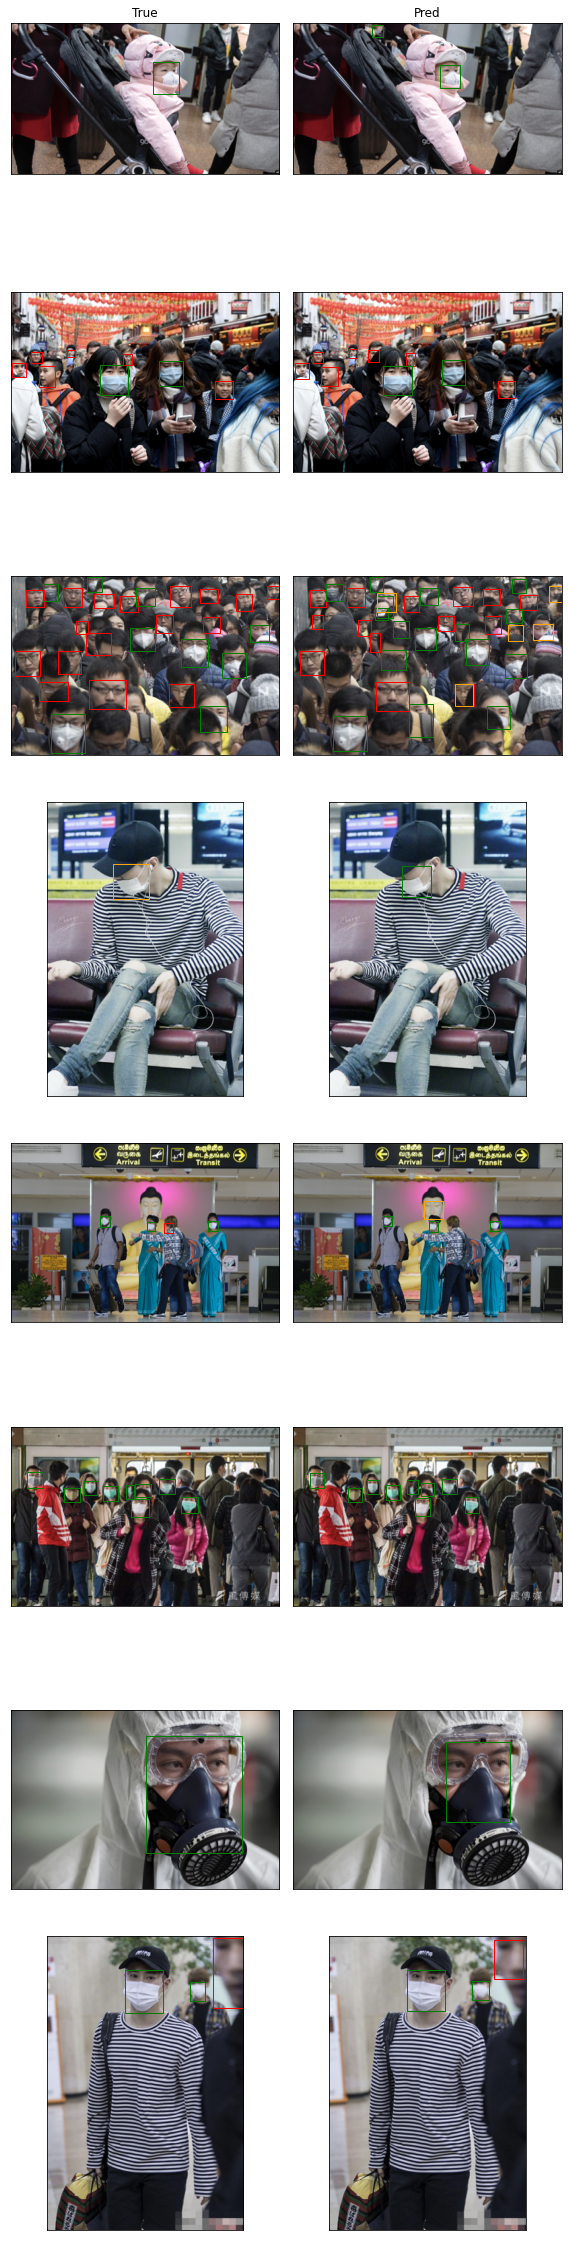

In [ ]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

On the code above, for loop is used to visualize true value and predicted value of 4 batches of images, which add up to total of 8 images. Left column denotes the true bounding boxes and labels while right column denotes the predicted bounding boxes and labels. The model seems to detect mask wearer (green) well. However, it sometimes detects non-mask wearer (red) as mask not correctly worn (orange). In order to assess the overall performance of the model, we will calculate mean Average Precision (mAP). mAP is a widely-used metric for evaluating object detection models.

There is a utils_ObjectDetection.py file in the Tutorial-Book-Utils folder that was loaded when downloading the data. Let's calculate the mAP by using a function in the module. First, we will load the utils_ObjectDetection.py module.

In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

We will save the information needed to calculate the mAP for each batch as `sample_metrics` and use the `ap_per_class` function to calculate the mAP. 

In [ ]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5824690281035101
AP : tensor([0.7684, 0.9188, 0.0603], dtype=torch.float64)


The results show an AP of 0.7684 for objects not wearing a mask, 0.9188 for objects wearing a mask, and 0.06 for objects not properly wearing a mask. The label for each of the objects are 0, 1, and 2, respectively.

So far, we have performed transfer learning with RetinaNet to create a medical mask detection model. In the next chapter, we will improve detection performance using Faster R-CNN, a two-stage detector. 